## Discussion Section Week 2 - 4/18/25

Please download, this file for the discussion section:  https://drive.google.com/file/d/16ROg2r9ziZpxww90cbOOKMMNfW-ZLZ0M/view?usp=sharing

Also make sure you have either a conda environment or a python environment with the packages pandas, numpy, and matplotlib installed. 

### Tshark Installation

Tshark should come installed with Wireshark, but if not please make sure you do so. If you are having trouble it may be it is not on your PATH variable. 

Installation instructions: https://tshark.dev/setup/install/


### Intro to Tshark

 TShark is a popular protocol analyzer. TShark is a terminal oriented version of Wireshark designed for capturing and displaying packets when an interactive user interface isn’t necessary or available. It supports the same options as wireshark. It lets you capture packet data from a live network, or read packets from a previously saved capture file, either printing a decoded form of those packets to the standard output or writing the packets to a file. 

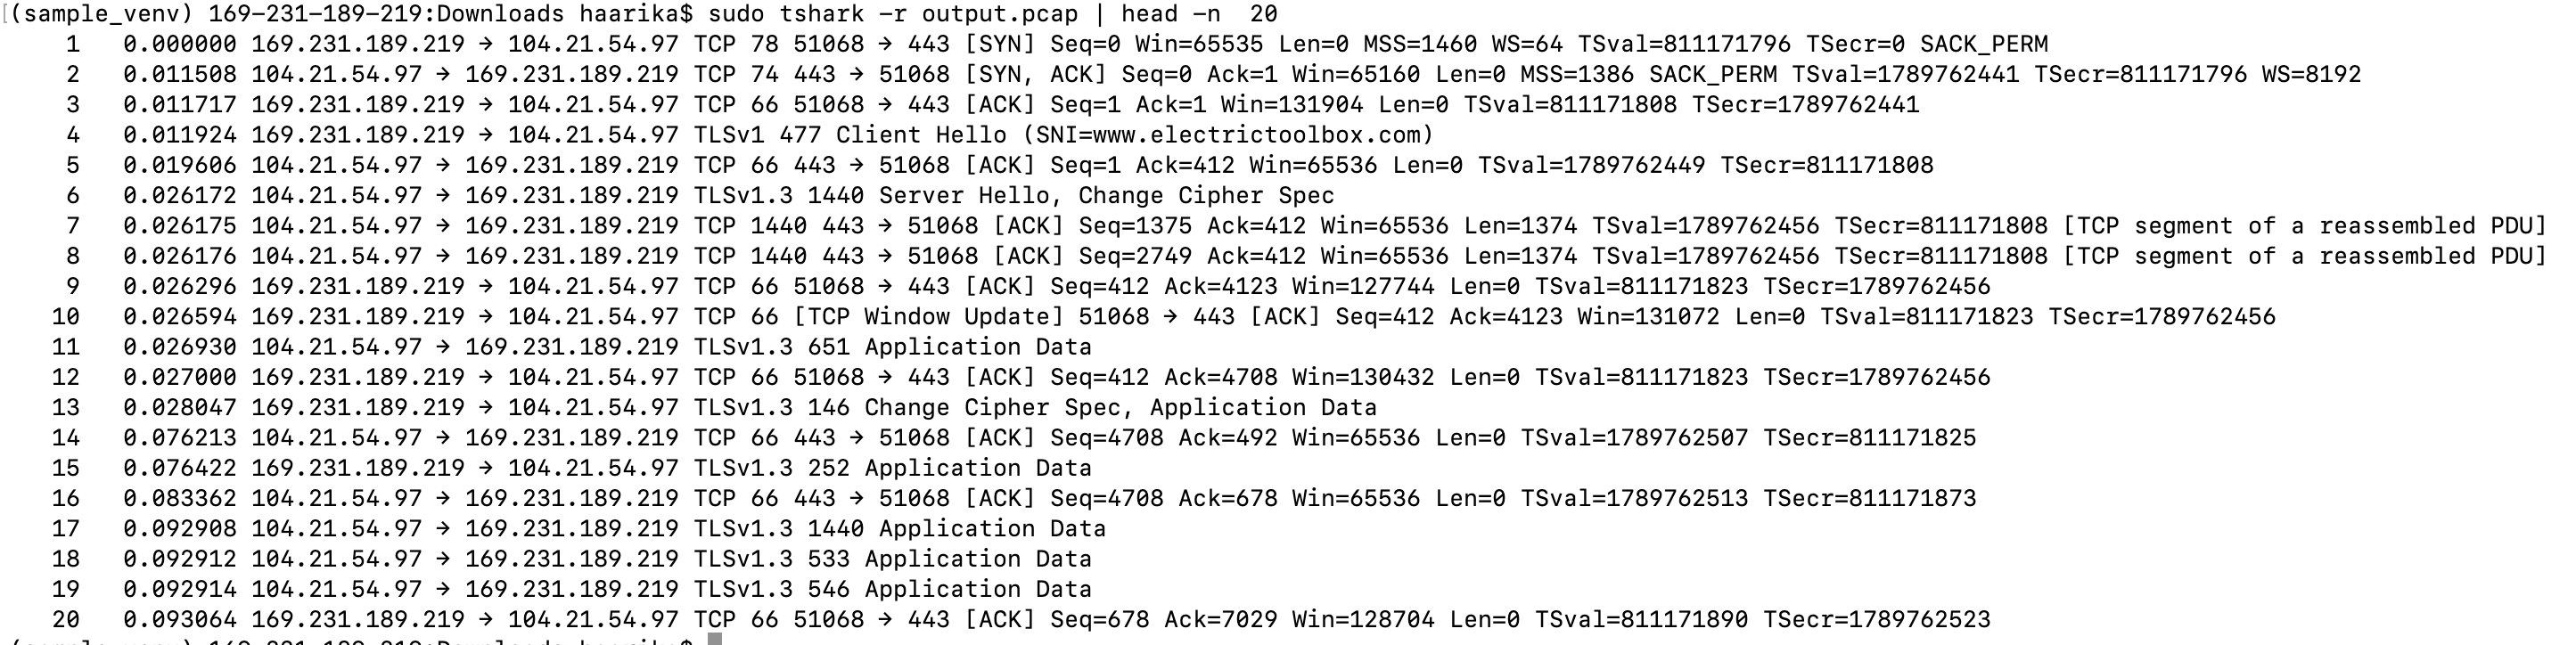

##### Basic Commands


tshark -h #(the manual and different command line information)
tshark -r example.pcap | head #(reading first 10 lines of a pcap file)
tshark -r example.pcap tcp.port == 80 || udp.port == 80 #(similar to wireshark you can filter what is displayed using port numbers)

Refer to the below manual for more commands:
https://www.wireshark.org/docs/man-pages/tshark.html


You can use TShark to extract statistical information from packet captures:

tshark  -r output.pcap -z io,phs

### Understanding TCP flags

This pcap contains the network traffic of a client downloading files using the 'wget' command.  Download the pcap and try to answer the following questions using TShark's command-line tools. Consult the tshark manual for help, in-case you want to know any specific commands.  

What are the total number of frames and bytes in this packet capture? 

What is the IP address of the client server ?

How many host server's is the client communicating with ?

What is the IP address of the host server that accounted for the majority of the traffic?

At what time-stamp did the client send it's final ACK packet to the server that accounted for the least amount of traffic?

Is there any difference with how the client ends its connection with each of the host servers? Explain. (Hint: look at the TCP Flags)


- **Answers:**
    - What are the total number of frames and bytes in this packet capture? 
        ```
        sudo tshark -r output.pcap -q -z io,stat,0
        193584 frames and  260,593,584 bytes
        ```

    - What is the IP address of the client server ?
        ```
        sudo tshark -n -r output.pcap -q -z conv,tcp 
        169.231.189.219
        ```

    - How many host server's is the client communicating with ?
        ```
        sudo tshark -n -r output.pcap -q -z conv,tcp 
        2
        ```

    - What is the IP address of the host server that accounted for the majority of the traffic?
        ```
        sudo tshark -n -r output.pcap -q -z conv,tcp 
        91.189.91.123
        ```

    - At what time-stamp did the client send its final acknowledgement packet to the server with lesser traffic?
        ```
        sudo tshark -r output.pcap -c 50
        0.104548
        ```

    - Is there any difference with how the client ends its connection with these host servers? Explain. (Hint: look at the TCP Flags)
        ```
        sudo tshark -r output.pcap -Y "tcp.flags.fin == 1 or tcp.flags.reset == 1" -T fields -e frame.time_relative -e ip.src -e ip.dst -e tcp.flags -E header=y -E separator=, 
        The first connection with 104.21.54.97, was a graceful termination indicated by both the client and the server sending FIN & ACK flags. In the second connection with 91.189.91.123, it indicates an abrupt termination that was aborted in an unsatisfactory manner.
        This is typically the results of errors, as evidenced by the RST flag being used.
        ```


### Extracing PCAP data to a CSV

TShark does not provide a robust interface for more fine-grained analysis of pcaps, therefore we often want to convert the extracted data into a csv. 
Say I want visualize how this data looks in a time-series format as a graph, for this we can choose our required fields. 

sudo tshark -r output.pcap -T fields -e frame.time_relative > time_stamps.csv

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


In [60]:

data = pd.read_csv('/Users/haarika/Downloads/time_stamps.csv', header=None, names=['Epoch'])
# Convert Epoch time to datetime
data['Timestamp'] = pd.to_datetime(data['Epoch'],unit='s')
# Set datetime as the index
data.set_index('Timestamp', inplace=True)
# The resample command downsamples the time stamps into bins of 1 second and counts the number of packets in these bins
per_second = data.resample('s').count()
print(per_second)

                     Epoch
Timestamp                 
1970-01-01 00:00:00     25
1970-01-01 00:00:01      0
1970-01-01 00:00:02      0
1970-01-01 00:00:03      0
1970-01-01 00:00:04      0
1970-01-01 00:00:05      0
1970-01-01 00:00:06     15
1970-01-01 00:00:07  10427
1970-01-01 00:00:08  25972
1970-01-01 00:00:09  17177
1970-01-01 00:00:10  20504
1970-01-01 00:00:11  26369
1970-01-01 00:00:12  26320
1970-01-01 00:00:13  23586
1970-01-01 00:00:14  10784
1970-01-01 00:00:15  15583
1970-01-01 00:00:16  16822


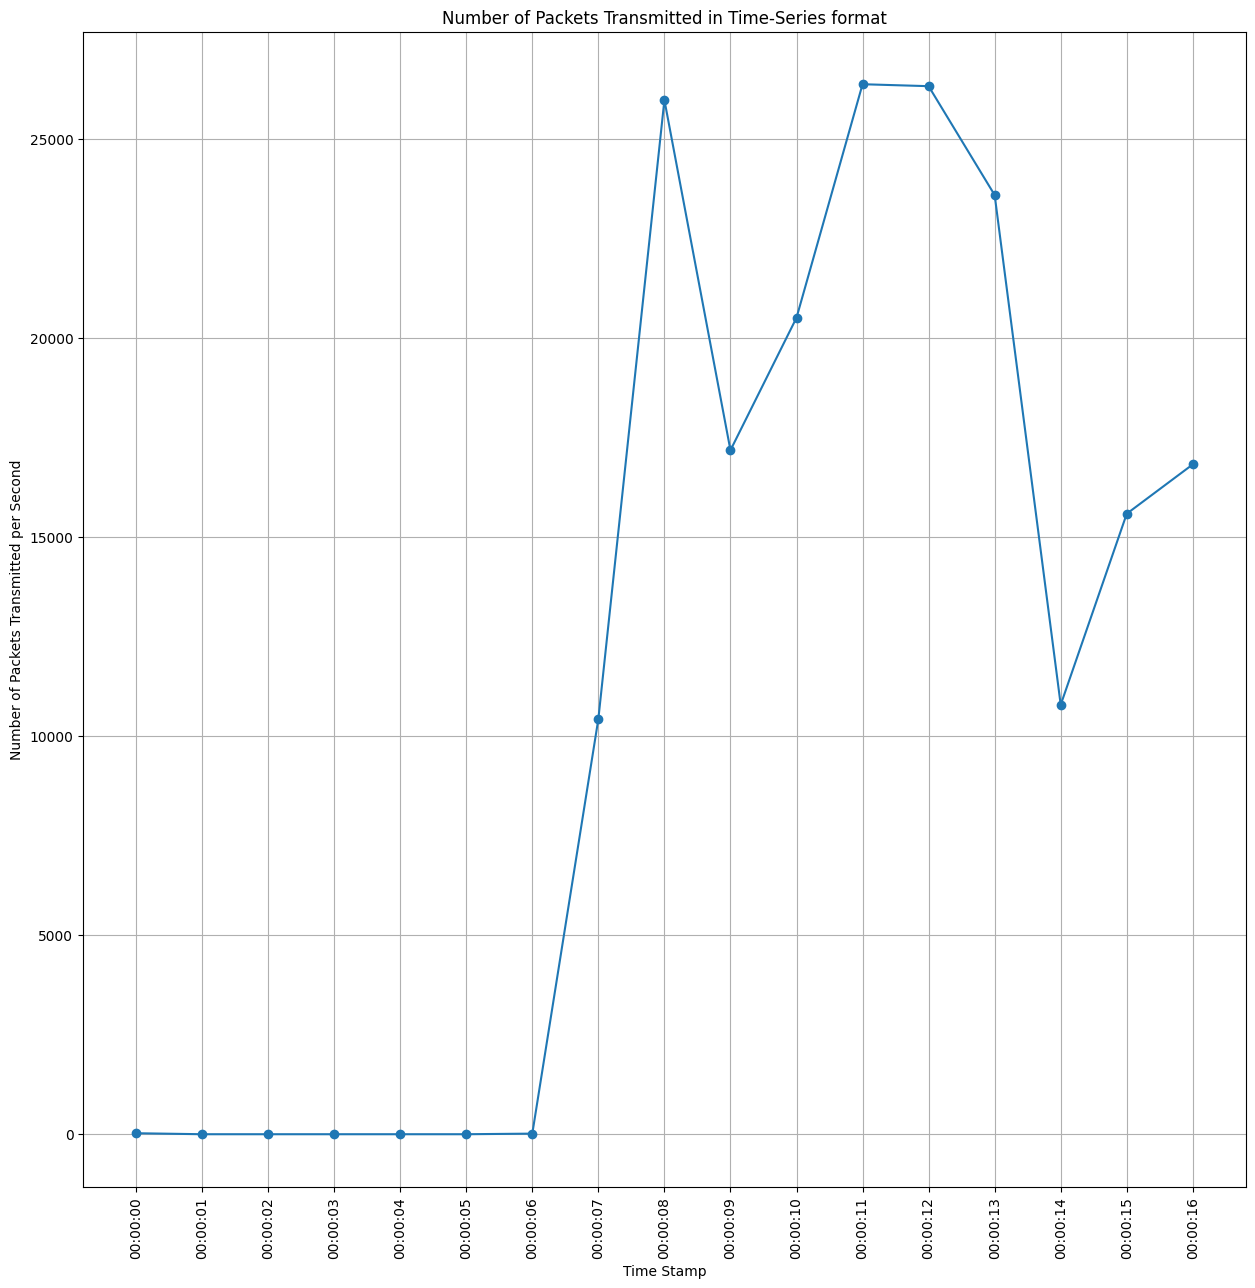

In [64]:

plt.figure(figsize=(15,15))
plt.plot(per_second.index, per_second['Epoch'], marker='o')
plt.title('Number of Packets Transmitted in Time-Series format')
plt.xlabel('Time Stamp')
date_range = pd.date_range(start=data.index.min(), end=data.index.max(), freq='S')
plt.xticks(date_range, labels=date_range.strftime('%H:%M:%S'), rotation=90)
plt.ylabel('Number of Packets Transmitted per Second')
plt.grid(True)
plt.show()

Let's look at other packet fields. How about the packet length ? We can do the same thing as earlier and write a command to extract these values. 
Try to write this command yourself. 

Answer:

sudo tshark -r output.pcap -T fields -e frame.len -E header=y -E separator=, > packet_sizes.csv

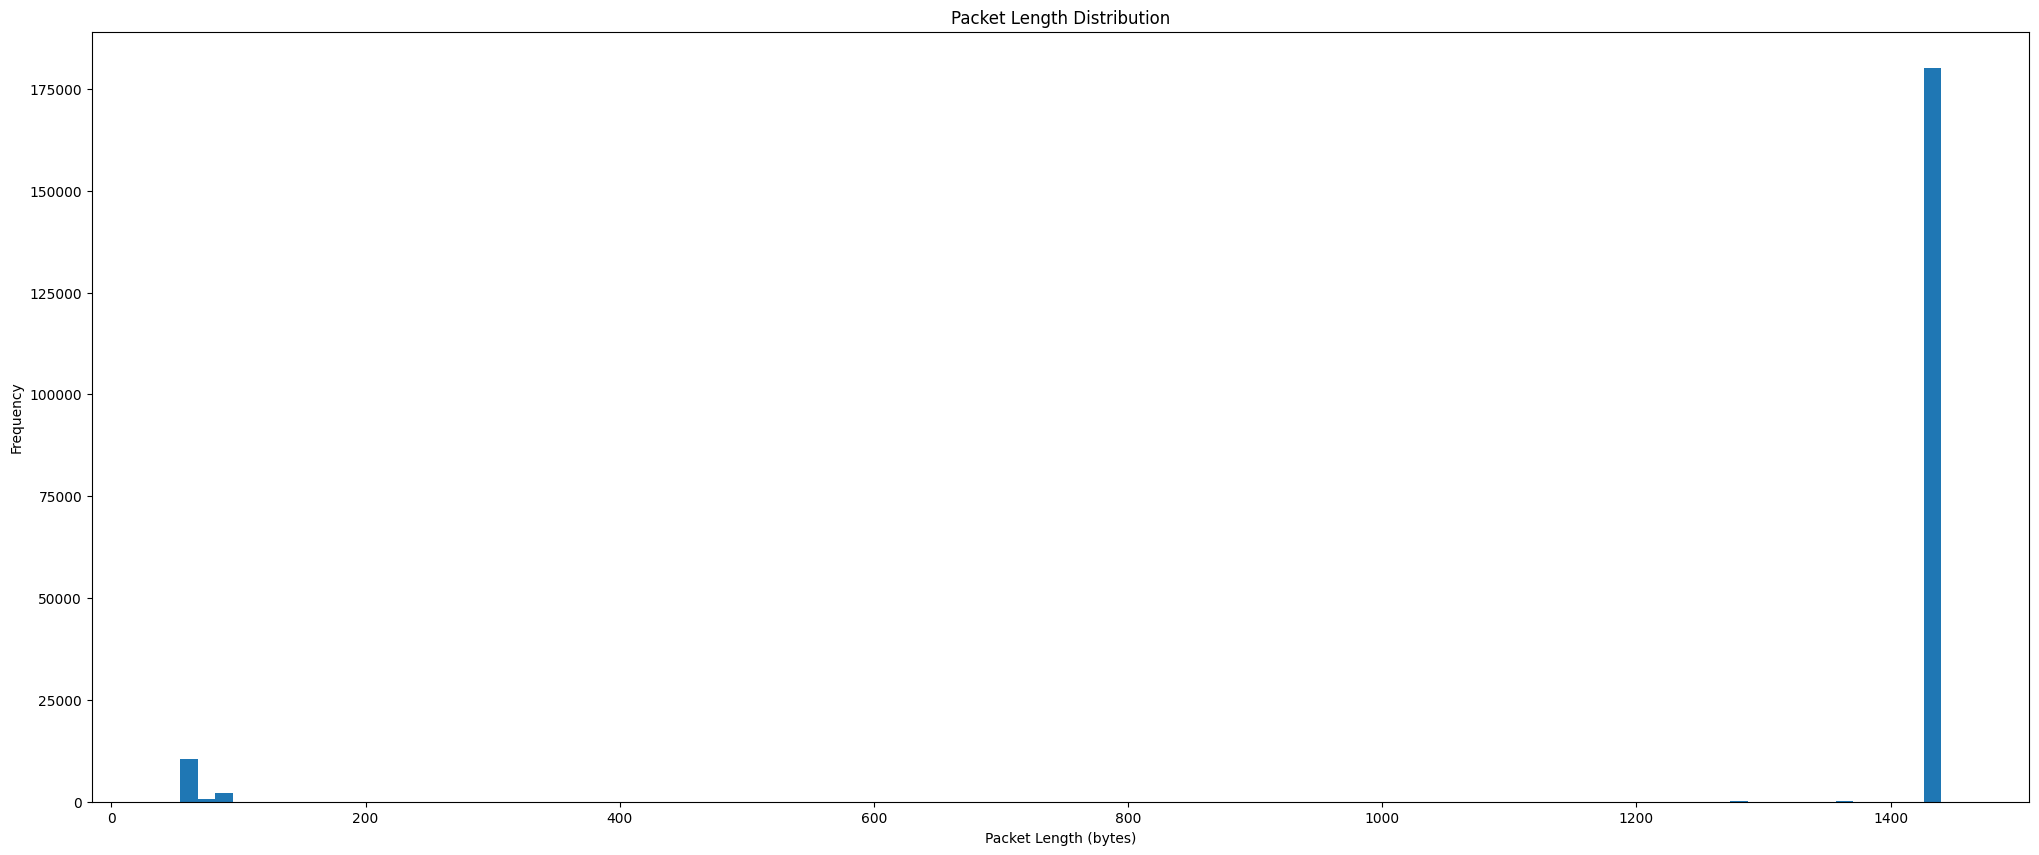

In [77]:
packet_sizes = pd.read_csv('/Users/haarika/Downloads/packet_sizes.csv', header=0, names=['Size'])

plt.figure(figsize=(25, 10))
plt.hist(packet_sizes['Size'],bins=100)

plt.title('Packet Length Distribution')
plt.xlabel('Packet Length (bytes)')
plt.ylabel('Frequency')

plt.show()

The maximum packet length transmitted in our capture is 1440. Why is this the case ? 

Answer: The maximum segment size is set to 1460. 

But wait where are the extra 20 bytes ? 

Answer: The extra 20 bytes are used for the tcp header which is typically 20 bytes in size. 